<a href="https://colab.research.google.com/github/dani2442/2026-Hybrid-Signal-Learning/blob/helon/BAB_NODE_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAB Dataset: Linear & Nonlinear Models

Organized training and simulation for linear, Stribeck, and black-box models.

In [139]:
!pip install torchdiffeq git+https://github.com/helonayala/bab_datasets.git
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import bab_datasets as nod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


  Cloning https://github.com/helonayala/bab_datasets.git to /tmp/pip-req-build-p9x8yg52
  Running command git clone --filter=blob:none --quiet https://github.com/helonayala/bab_datasets.git /tmp/pip-req-build-p9x8yg52
  Resolved https://github.com/helonayala/bab_datasets.git to commit cf60b6ee8d7fb1fa448705848261ad490bfeed6d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using device: cuda


## 1) Load Data

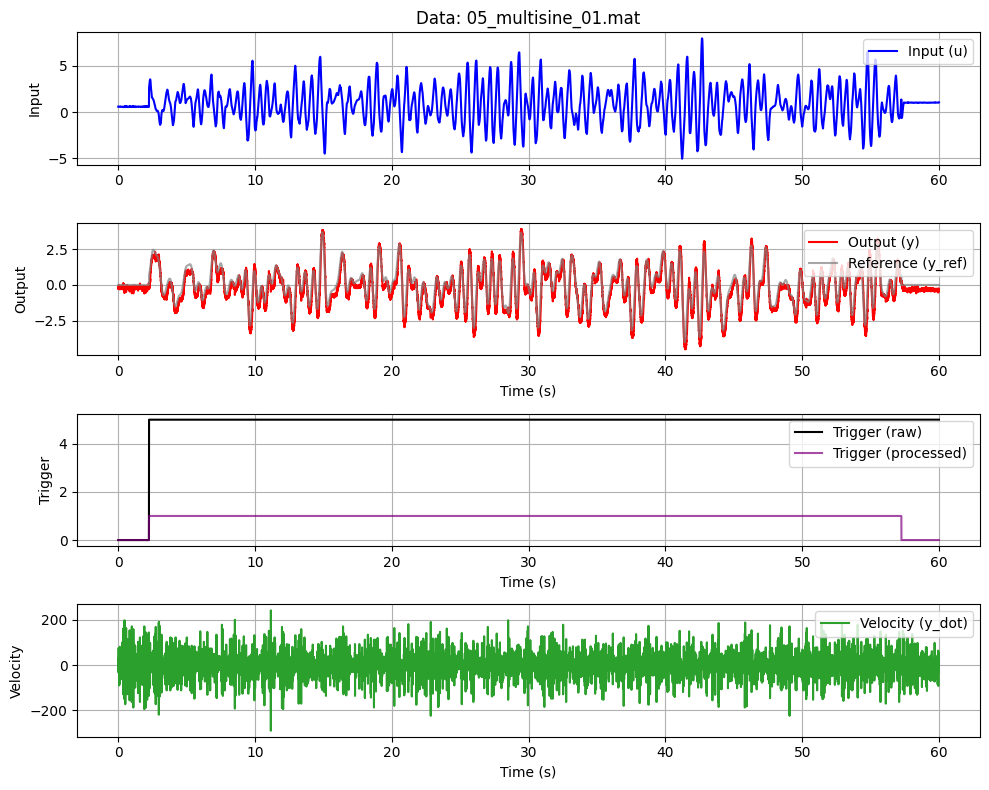

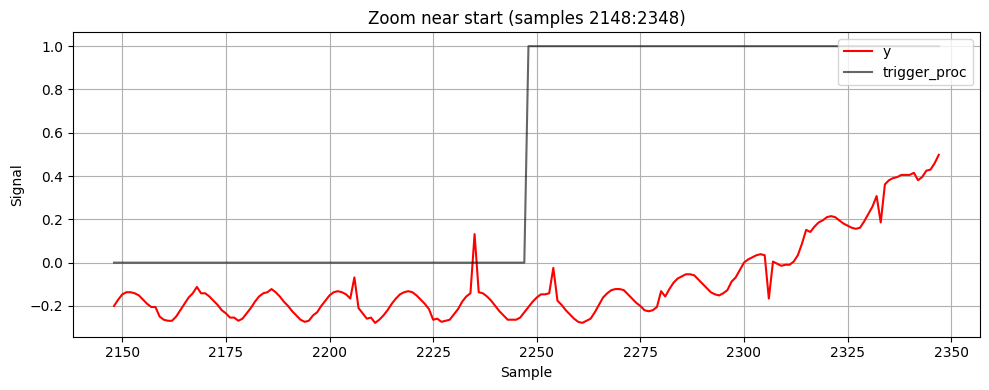

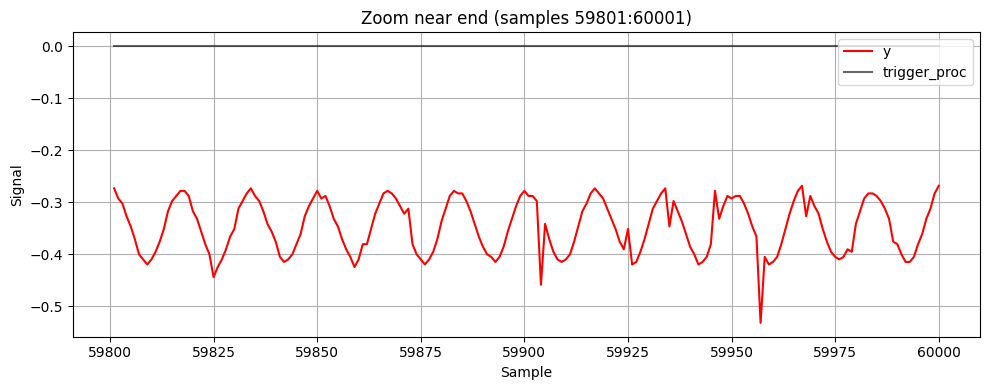

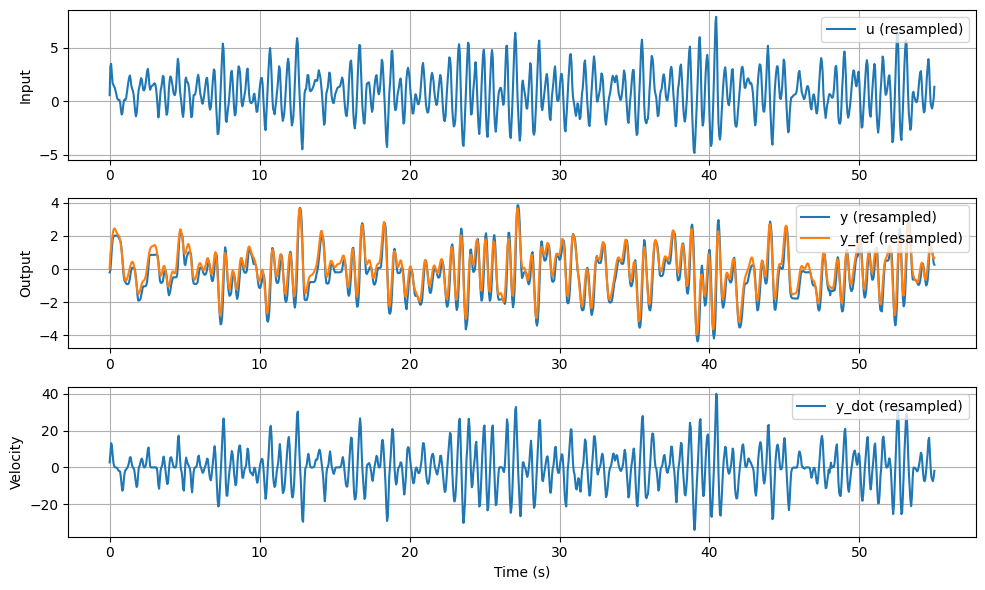

In [140]:
velMethod = "central"

data = nod.load_experiment(
    "multisine_05",
    preprocess=True,
    plot=True,
    end_idx=None,
    resample_factor=50,
    zoom_last_n=200,
    y_dot_method=velMethod,
)

u, y, y_ref, y_dot = data
Ts = data.sampling_time
t = np.arange(len(u)) * Ts

y_sim = np.column_stack([y, y_dot])


## 2) Tensor Prep

In [141]:
t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
u_tensor = torch.tensor(u, dtype=torch.float32).reshape(-1, 1).to(device)
y_tensor = torch.tensor(y_sim, dtype=torch.float32).to(device)


## 3) Model Definitions

In [142]:
class LinearPhysODE(nn.Module):
    # J*thdd + R*thd + K*(th+delta) = Tau*V
    def __init__(self):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)
        return J, R, K, self.delta, Tau

    def forward(self, t, x):
        J, R, K, delta, Tau = self.get_params()
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        thdd = (Tau * u_t - R * thd - K * (th + delta)) / J
        return torch.cat([thd, thdd], dim=1)


class StribeckPhysODE(nn.Module):
    # J*thdd + R*thd + K*(th+delta) + F_stribeck = Tau*V
    def __init__(self):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))

        self.log_Fc = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_Fs = nn.Parameter(torch.tensor(np.log(0.2), dtype=torch.float32))
        self.log_vs = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_b = nn.Parameter(torch.tensor(np.log(0.01), dtype=torch.float32))

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)
        Fc = torch.exp(self.log_Fc)
        Fs = torch.exp(self.log_Fs)
        vs = torch.exp(self.log_vs)
        b = torch.exp(self.log_b)
        return J, R, K, self.delta, Tau, Fc, Fs, vs, b

    def forward(self, t, x):
        J, R, K, delta, Tau, Fc, Fs, vs, b = self.get_params()
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        sgn = torch.tanh(thd / 1e-3)
        F_str = (Fc + (Fs - Fc) * torch.exp(-(thd / vs) ** 2)) * sgn + b * thd
        thdd = (Tau * u_t - R * thd - K * (th + delta) - F_str) / J
        return torch.cat([thd, thdd], dim=1)


class BlackBoxODE(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 2)
        )
        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def forward(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)
        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        nn_input = torch.cat([x, u_t], dim=1)
        return self.net(nn_input)


class HybridJointODE(nn.Module):
    # thdd = physics(theta, theta_dot, u) + NN residual
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))

        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def _interp_u(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)

        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        return u1 + alpha * (u2 - u1)

    def forward(self, t, x):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)

        u_t = self._interp_u(t, x)
        th, thd = x[:, 0:1], x[:, 1:2]

        thdd_phys = (Tau * u_t - R * thd - K * (th + self.delta)) / J
        thdd_res = self.net(torch.cat([th, thd, u_t], dim=1))
        thdd = thdd_phys + thdd_res
        return torch.cat([thd, thdd], dim=1)


class HybridFrozenPhysODE(nn.Module):
    # thdd = frozen physics(theta, theta_dot, u) + NN residual
    def __init__(self, phys_model, hidden_dim=128):
        super().__init__()
        J0, R0, K0, delta0, Tau0 = phys_model.get_params()
        self.register_buffer('J0', J0.detach().clone())
        self.register_buffer('R0', R0.detach().clone())
        self.register_buffer('K0', K0.detach().clone())
        self.register_buffer('delta0', delta0.detach().clone())
        self.register_buffer('Tau0', Tau0.detach().clone())

        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.AlphaDropout(0.05),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def _interp_u(self, t, x):
        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)

        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]
        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        return u1 + alpha * (u2 - u1)

    def forward(self, t, x):
        u_t = self._interp_u(t, x)
        th, thd = x[:, 0:1], x[:, 1:2]

        thdd_phys = (self.Tau0 * u_t - self.R0 * thd - self.K0 * (th + self.delta0)) / self.J0
        thdd_res = self.net(torch.cat([th, thd, u_t], dim=1))
        thdd = thdd_phys + thdd_res
        return torch.cat([thd, thdd], dim=1)


## 4) Training Helper

In [143]:
def train_model_obs(model, name, epochs=500, lr=0.02, obs_dim=2):
    print(f"--- Training {name} ---")
    model.to(device)
    model.u_series = u_tensor
    model.t_series = t_tensor

    optimizer = optim.Adam(model.parameters(), lr=lr)
    K_STEPS = 20
    BATCH_SIZE = 128
    dt_local = (t_tensor[1] - t_tensor[0]).item()
    t_eval = torch.arange(0, K_STEPS * dt_local, dt_local, device=device)

    for epoch in range(epochs + 1):
        optimizer.zero_grad()

        # IC uses both theta and theta_dot
        start_idx = np.random.randint(0, len(t_tensor) - K_STEPS, size=BATCH_SIZE)
        x0 = y_tensor[start_idx]
        model.batch_start_times = t_tensor[start_idx].reshape(-1, 1)

        pred_state = odeint(model, x0, t_eval, method='rk4')
        pred_obs = pred_state[..., :obs_dim]

        batch_targets = []
        for i in start_idx:
            batch_targets.append(y_tensor[i:i + K_STEPS])
        y_target = torch.stack(batch_targets, dim=1)  # [T, B, 2]

        # Position-only loss (theta), velocity not used in supervision
        pred_pos = pred_obs[..., 0:1]
        target_pos = y_target[..., 0:1]
        loss = torch.mean((pred_pos - target_pos) ** 2)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

    return model

## 5) Train Linear Model

In [144]:
lin_model = LinearPhysODE()
lin_model = train_model_obs(lin_model, "Linear Model", epochs=1000, lr=0.01)


--- Training Linear Model ---
Epoch 0 | Loss: 7.093011
Epoch 100 | Loss: 1.110324
Epoch 200 | Loss: 0.516626
Epoch 300 | Loss: 0.419859
Epoch 400 | Loss: 0.308406
Epoch 500 | Loss: 0.305968
Epoch 600 | Loss: 0.233237
Epoch 700 | Loss: 0.199788
Epoch 800 | Loss: 0.222516
Epoch 900 | Loss: 0.175597
Epoch 1000 | Loss: 0.197559


## 6) Train Stribeck Model

In [145]:
str_model = StribeckPhysODE()
str_model = train_model_obs(str_model, "Stribeck Model", epochs=1000, lr=0.01)


--- Training Stribeck Model ---
Epoch 0 | Loss: 5.586030
Epoch 100 | Loss: 1.065059
Epoch 200 | Loss: 0.554718
Epoch 300 | Loss: 0.386467
Epoch 400 | Loss: 0.298141
Epoch 500 | Loss: 0.236477
Epoch 600 | Loss: 0.196318
Epoch 700 | Loss: 0.193798
Epoch 800 | Loss: 0.178349
Epoch 900 | Loss: 0.121987
Epoch 1000 | Loss: 0.124623


## 7) Train Black-box Model

In [146]:
bb_model = BlackBoxODE(hidden_dim=128)
bb_model = train_model_obs(bb_model, "Black-Box Model", epochs=1000, lr=0.01)


--- Training Black-Box Model ---
Epoch 0 | Loss: 3.312763
Epoch 100 | Loss: 0.100362
Epoch 200 | Loss: 0.040733
Epoch 300 | Loss: 0.021736
Epoch 400 | Loss: 0.027598
Epoch 500 | Loss: 0.036660
Epoch 600 | Loss: 0.020965
Epoch 700 | Loss: 0.039352
Epoch 800 | Loss: 0.077677
Epoch 900 | Loss: 0.031439
Epoch 1000 | Loss: 0.025932


## 8) Train Hybrid Joint Model

In [ ]:
hjoint_model = HybridJointODE(hidden_dim=128)
hjoint_model = train_model_obs(hjoint_model, "Hybrid-Joint Model", epochs=1000, lr=0.01)


## 9) Train Hybrid Frozen-Physics Model

In [ ]:
hfrozen_model = HybridFrozenPhysODE(lin_model, hidden_dim=128)
hfrozen_model = train_model_obs(hfrozen_model, "Hybrid-Frozen Model", epochs=1000, lr=0.01)


## 8) Simulate Linear Model

In [147]:
with torch.no_grad():
    lin_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_lin = odeint(lin_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 9) Simulate Stribeck Model

In [148]:
with torch.no_grad():
    str_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_str = odeint(str_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 10) Simulate Black-box Model

In [149]:
with torch.no_grad():
    bb_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_bb = odeint(bb_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 12) Simulate Hybrid Joint Model

In [ ]:
with torch.no_grad():
    hjoint_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_hjoint = odeint(hjoint_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 13) Simulate Hybrid Frozen-Physics Model

In [ ]:
with torch.no_grad():
    hfrozen_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)
    pred_hfrozen = odeint(hfrozen_model, x0, t_tensor, method='rk4').squeeze(1).cpu().numpy()


## 11) Comparison Plots

Metrics - Position
Model        RMSE      R2        FIT%
Linear       0.5324    0.8497   61.24   
Stribeck     0.4910    0.8722   64.25   
Black-box    0.2416    0.9691   82.41   
Metrics - Velocity
Model        RMSE      R2        FIT%
Linear       1.9858    0.9655   81.43   
Stribeck     1.6643    0.9758   84.44   
Black-box    1.2631    0.9861   88.19   


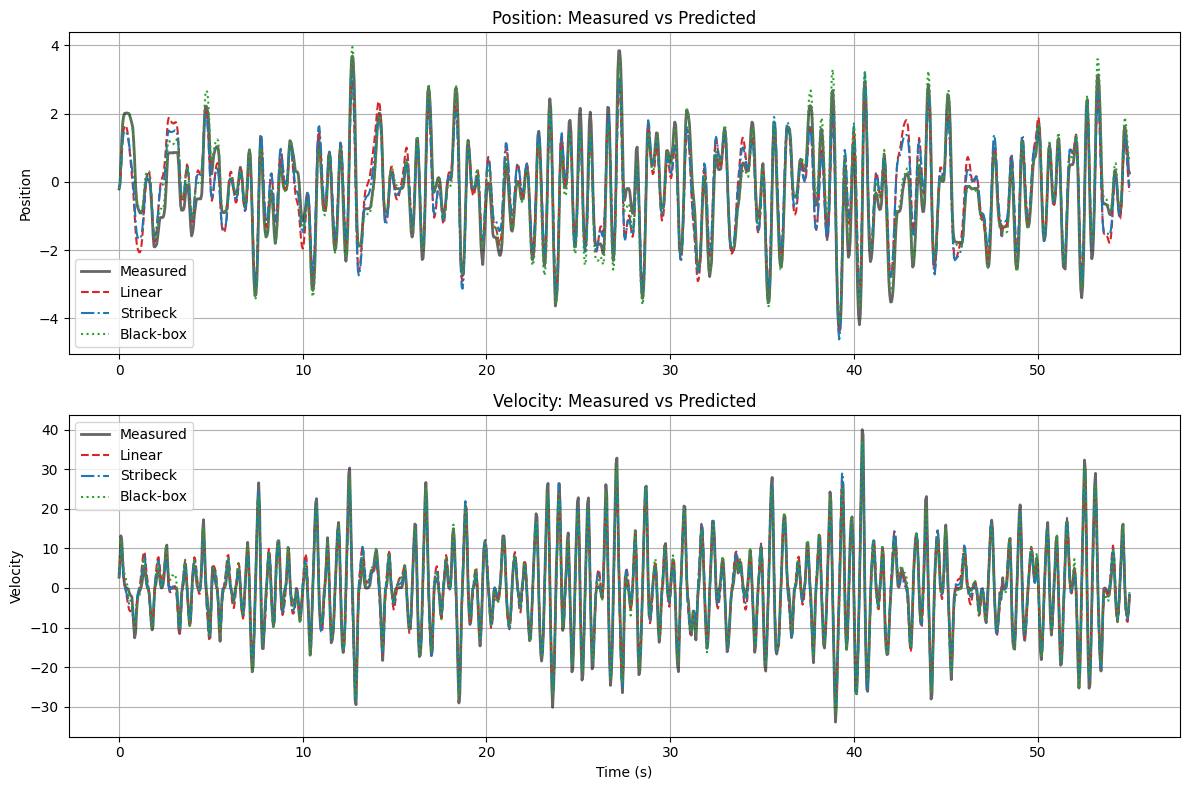

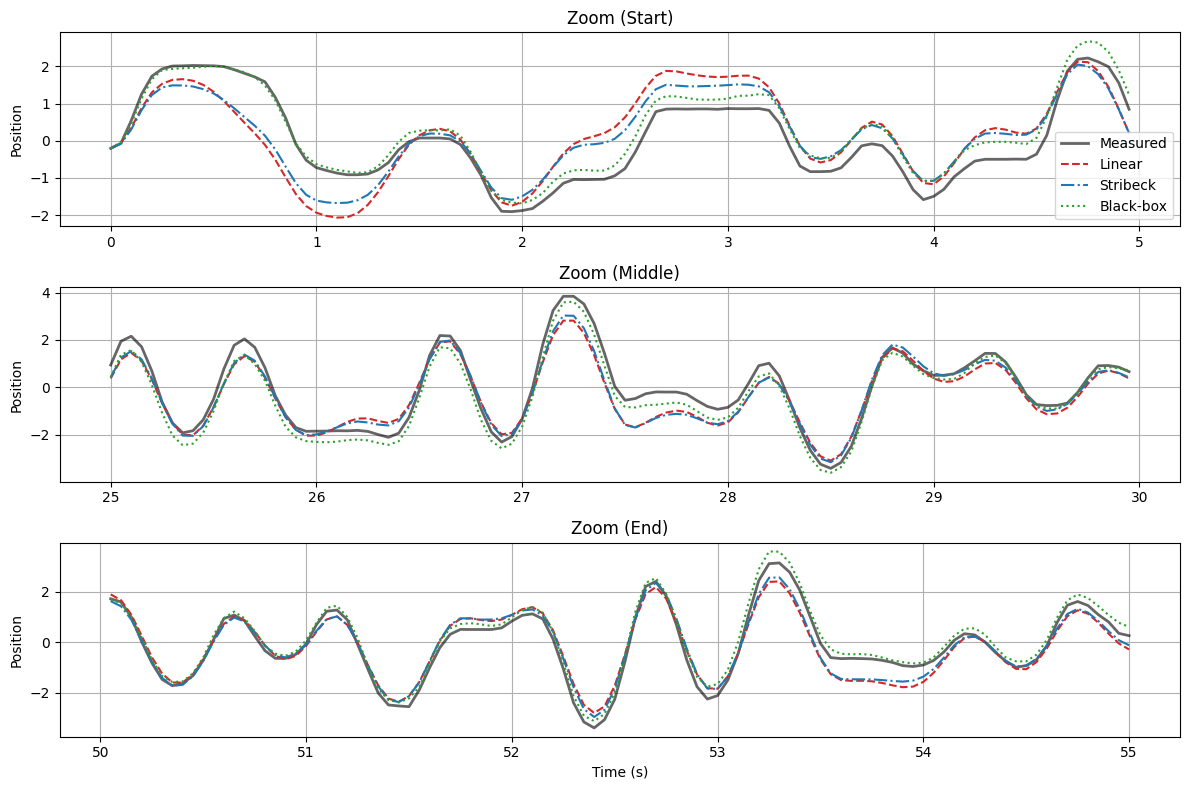

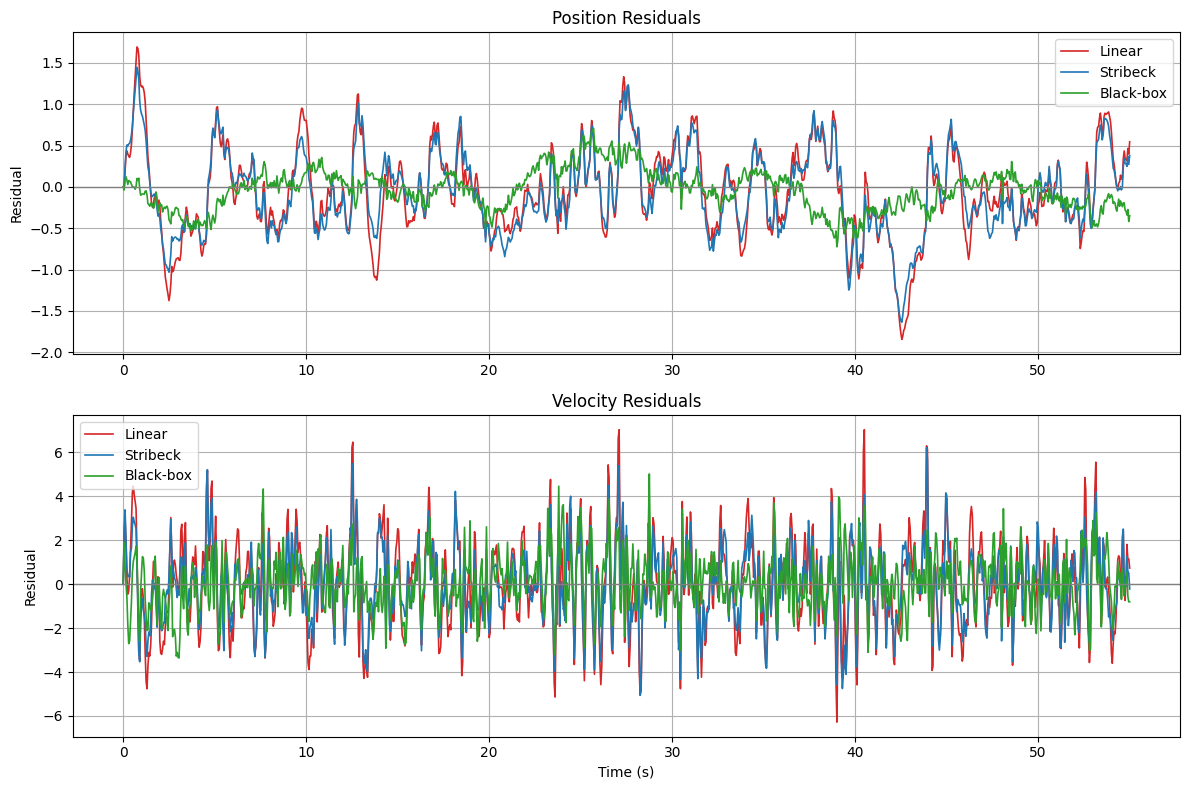

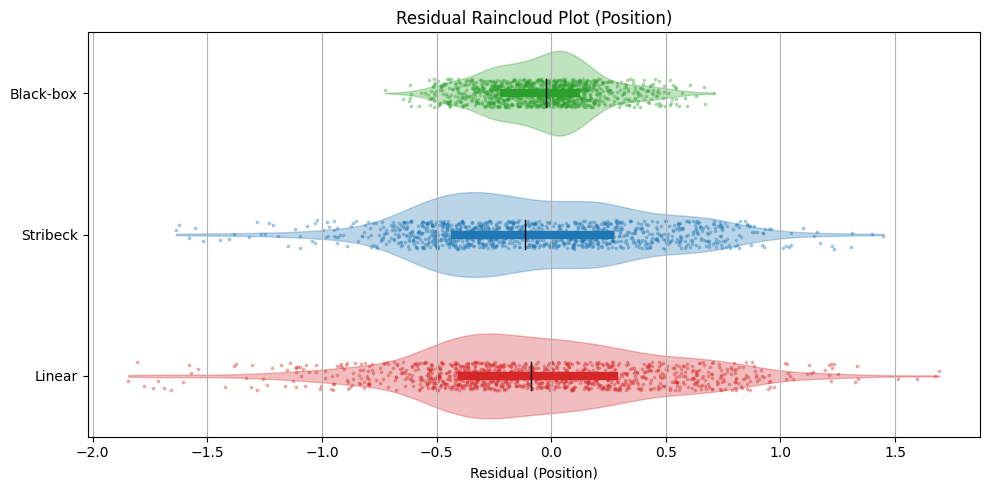

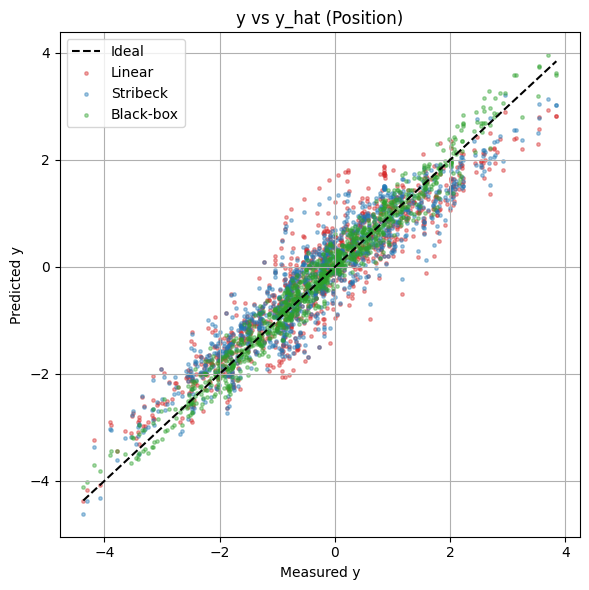

In [150]:
# Metrics and residuals for all models
models = {
    "Linear": pred_lin,
    "Stribeck": pred_str,
    "Black-box": pred_bb,
    "Hybrid-Joint": pred_hjoint,
    "Hybrid-Frozen": pred_hfrozen,
}
colors = {
    "Linear": "tab:red",
    "Stribeck": "tab:blue",
    "Black-box": "tab:green",
    "Hybrid-Joint": "tab:orange",
    "Hybrid-Frozen": "tab:purple",
}
styles = {
    "Linear": "--",
    "Stribeck": "-.",
    "Black-box": ":",
    "Hybrid-Joint": "-",
    "Hybrid-Frozen": (0, (3, 1, 1, 1)),
}

residuals = {}
metrics = {}
for name, pred in models.items():
    res_pos = y_sim[:, 0] - pred[:, 0]
    res_vel = y_sim[:, 1] - pred[:, 1]
    rmse_pos = np.sqrt(np.mean(res_pos**2))
    rmse_vel = np.sqrt(np.mean(res_vel**2))
    ss_res_pos = np.sum(res_pos**2)
    ss_tot_pos = np.sum((y_sim[:, 0] - np.mean(y_sim[:, 0]))**2)
    ss_res_vel = np.sum(res_vel**2)
    ss_tot_vel = np.sum((y_sim[:, 1] - np.mean(y_sim[:, 1]))**2)
    r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
    r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan
    fit_pos = 100 * (1 - np.linalg.norm(res_pos) / np.linalg.norm(y_sim[:, 0] - np.mean(y_sim[:, 0])))
    fit_vel = 100 * (1 - np.linalg.norm(res_vel) / np.linalg.norm(y_sim[:, 1] - np.mean(y_sim[:, 1])))
    residuals[name] = {"pos": res_pos, "vel": res_vel}
    metrics[name] = {"rmse_pos": rmse_pos, "rmse_vel": rmse_vel, "r2_pos": r2_pos, "r2_vel": r2_vel, "fit_pos": fit_pos, "fit_vel": fit_vel}

# Metrics tables
print("Metrics - Position")
print("Model        RMSE      R2        FIT%")
for name in models.keys():
    m = metrics[name]
    print(f"{name:<12} {m['rmse_pos']:<9.4f} {m['r2_pos']:<8.4f} {m['fit_pos']:<8.2f}")

print("Metrics - Velocity")
print("Model        RMSE      R2        FIT%")
for name in models.keys():
    m = metrics[name]
    print(f"{name:<12} {m['rmse_vel']:<9.4f} {m['r2_vel']:<8.4f} {m['fit_vel']:<8.2f}")

# Comparison plots (no metrics in titles)
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_sim[:, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models.items():
    plt.plot(t, pred[:, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.title("Position: Measured vs Predicted")

plt.subplot(2, 1, 2)
plt.plot(t, y_sim[:, 1], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models.items():
    plt.plot(t, pred[:, 1], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)
plt.title("Velocity: Measured vs Predicted")

plt.tight_layout()
plt.show()

# Zooms (position only)
win_sec = 5.0
win_n = int(win_sec / Ts)
starts = [0, max(0, (len(t) - win_n) // 2), max(0, len(t) - win_n)]
labels = ["Start", "Middle", "End"]

plt.figure(figsize=(12, 8))
for i, s in enumerate(starts):
    e = min(len(t), s + win_n)
    plt.subplot(3, 1, i + 1)
    plt.plot(t[s:e], y_sim[s:e, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
    for name, pred in models.items():
        plt.plot(t[s:e], pred[s:e, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
    plt.title(f"Zoom ({labels[i]})")
    plt.ylabel('Position')
    plt.grid(True)
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Residuals (all models)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for name in models.keys():
    plt.plot(t, residuals[name]['pos'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title('Position Residuals')
plt.ylabel('Residual')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
for name in models.keys():
    plt.plot(t, residuals[name]['vel'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title('Velocity Residuals')
plt.ylabel('Residual')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Raincloud plot (position residuals)
from scipy.stats import gaussian_kde

labels = list(models.keys())
res_list = [residuals[name]['pos'] for name in labels]

plt.figure(figsize=(10, 5))
for i, (label, res) in enumerate(zip(labels, res_list)):
    res = res[np.isfinite(res)]
    kde = gaussian_kde(res)
    xs = np.linspace(np.min(res), np.max(res), 200)
    ys = kde(xs)
    ys = ys / ys.max() * 0.3
    plt.fill_between(xs, i + ys, i - ys, color=colors[label], alpha=0.3)
    q1, q2, q3 = np.percentile(res, [25, 50, 75])
    plt.plot([q1, q3], [i, i], color=colors[label], linewidth=6)
    plt.plot([q2, q2], [i-0.1, i+0.1], color='k', linewidth=1)
    jitter = (np.random.rand(len(res)) - 0.5) * 0.2
    plt.scatter(res, i + jitter, s=3, color=colors[label], alpha=0.3)

plt.yticks(range(len(labels)), labels)
plt.xlabel('Residual (Position)')
plt.title('Residual Raincloud Plot (Position)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# y vs yhat (position)
plt.figure(figsize=(6, 6))
plt.plot([y_sim[:,0].min(), y_sim[:,0].max()], [y_sim[:,0].min(), y_sim[:,0].max()], 'k--', label='Ideal')
for name, pred in models.items():
    plt.scatter(y_sim[:,0], pred[:,0], s=6, alpha=0.4, color=colors[name], label=name)
plt.xlabel('Measured y')
plt.ylabel('Predicted y')
plt.title('y vs y_hat (Position)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 12) Diagnostics (Position)

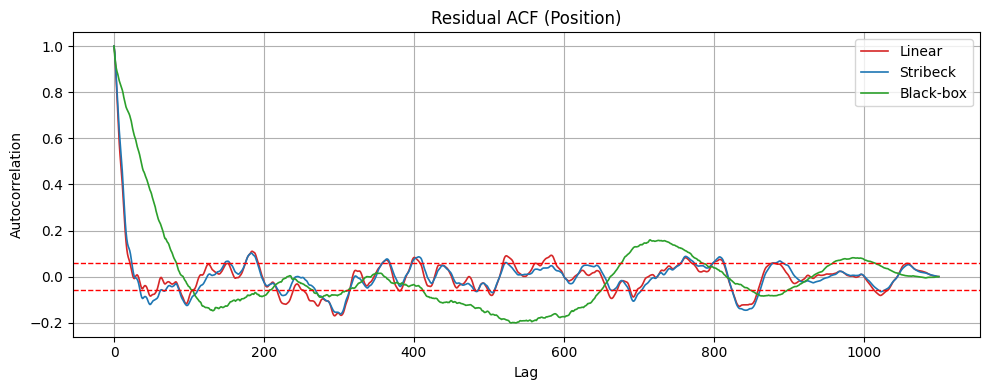

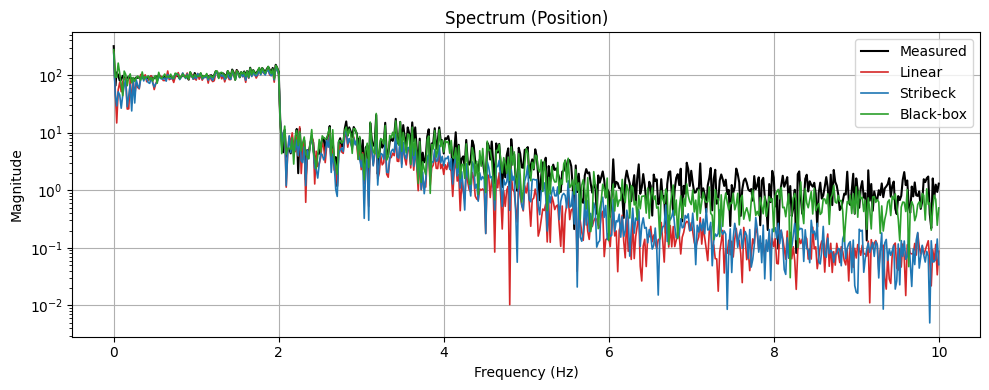

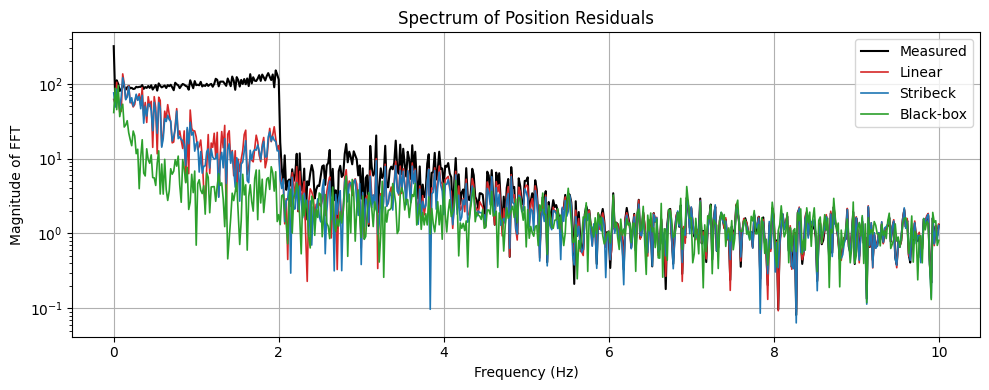

In [151]:
# Residual ACF (position) for all models
N = len(t)
max_lag = min(2000, N - 1)
conf = 1.96 / np.sqrt(N)

plt.figure(figsize=(10, 4))
for name in models.keys():
    res = residuals[name]['pos'] - np.mean(residuals[name]['pos'])
    acf = np.correlate(res, res, mode='full')
    acf = acf[N-1:N+max_lag] / acf[N-1]
    plt.plot(np.arange(0, max_lag+1), acf, color=colors[name], linewidth=1.2, label=name)

plt.axhline(conf, color='red', linestyle='--', linewidth=1)
plt.axhline(-conf, color='red', linestyle='--', linewidth=1)
plt.title('Residual ACF (Position)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum: measured vs predictions (position)
freqs = np.fft.rfftfreq(len(t), d=Ts)
Y_meas = np.fft.rfft(y_sim[:, 0])

plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_meas), color='k', label='Measured')
for name, pred in models.items():
    Y_pred = np.fft.rfft(pred[:, 0])
    plt.semilogy(freqs, np.abs(Y_pred), color=colors[name], linewidth=1.2, label=name)
plt.title('Spectrum (Position)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum of position residuals for all models
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_meas), color='k', label='Measured')
for name in models.keys():
    # Calculate FFT of position residuals
    res_fft = np.fft.rfft(residuals[name]['pos'])
    # Plot magnitude spectrum on a semilogy scale
    plt.semilogy(freqs, np.abs(res_fft), color=colors[name], linewidth=1.2, label=name)

plt.title('Spectrum of Position Residuals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of FFT')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 13) Load Test Data and run prediction



In [152]:
# Evaluate all datasets and store predictions for later plotting
model_objects = {
    "Linear": lin_model,
    "Stribeck": str_model,
    "Black-box": bb_model,
    "Hybrid-Joint": hjoint_model,
    "Hybrid-Frozen": hfrozen_model,
}

# Use every available dataset as test columns
test_datasets = nod.list_experiments()

# Stored results per dataset
# eval_store[dataset] = {
#   "t", "Ts", "y_sim", "preds", "residuals", "metrics"
# }
eval_store = {}

for ds_name in test_datasets:
    data_ds = nod.load_experiment(
        ds_name,
        preprocess=True,
        plot=False,
        end_idx=None,
        resample_factor=50,
        zoom_last_n=200,
        y_dot_method=velMethod,
    )

    u_ds, y_ds, y_ref_ds, y_dot_ds = data_ds
    Ts_ds = data_ds.sampling_time
    t_ds = np.arange(len(u_ds)) * Ts_ds
    y_sim_ds = np.column_stack([y_ds, y_dot_ds])

    t_ds_tensor = torch.tensor(t_ds, dtype=torch.float32).to(device)
    u_ds_tensor = torch.tensor(u_ds, dtype=torch.float32).reshape(-1, 1).to(device)
    y_ds_tensor = torch.tensor(y_sim_ds, dtype=torch.float32).to(device)

    preds_ds = {}
    with torch.no_grad():
        x0_ds = y_ds_tensor[0].unsqueeze(0)
        for model_name, model_obj in model_objects.items():
            model_obj.u_series = u_ds_tensor
            model_obj.t_series = t_ds_tensor
            model_obj.batch_start_times = torch.zeros(1, 1).to(device)
            pred = odeint(model_obj, x0_ds, t_ds_tensor, method='rk4').squeeze(1).cpu().numpy()
            preds_ds[model_name] = pred

    residuals_ds = {}
    metrics_ds = {}
    for model_name, pred in preds_ds.items():
        res_pos = y_sim_ds[:, 0] - pred[:, 0]
        res_vel = y_sim_ds[:, 1] - pred[:, 1]

        rmse_pos = np.sqrt(np.mean(res_pos**2))
        rmse_vel = np.sqrt(np.mean(res_vel**2))

        ss_res_pos = np.sum(res_pos**2)
        ss_tot_pos = np.sum((y_sim_ds[:, 0] - np.mean(y_sim_ds[:, 0]))**2)
        ss_res_vel = np.sum(res_vel**2)
        ss_tot_vel = np.sum((y_sim_ds[:, 1] - np.mean(y_sim_ds[:, 1]))**2)

        r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
        r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan

        fit_pos = 100 * (1 - np.linalg.norm(res_pos) / np.linalg.norm(y_sim_ds[:, 0] - np.mean(y_sim_ds[:, 0])))
        fit_vel = 100 * (1 - np.linalg.norm(res_vel) / np.linalg.norm(y_sim_ds[:, 1] - np.mean(y_sim_ds[:, 1])))

        residuals_ds[model_name] = {"pos": res_pos, "vel": res_vel}
        metrics_ds[model_name] = {
            "rmse_pos": rmse_pos,
            "rmse_vel": rmse_vel,
            "r2_pos": r2_pos,
            "r2_vel": r2_vel,
            "fit_pos": fit_pos,
            "fit_vel": fit_vel,
        }

    eval_store[ds_name] = {
        "t": t_ds,
        "Ts": Ts_ds,
        "y_sim": y_sim_ds,
        "preds": preds_ds,
        "residuals": residuals_ds,
        "metrics": metrics_ds,
    }

# Build R2 tables: rows = models, columns = datasets
model_names = list(model_objects.keys())
r2_pos_table = np.zeros((len(model_names), len(test_datasets)))
r2_vel_table = np.zeros((len(model_names), len(test_datasets)))

for i, mname in enumerate(model_names):
    for j, ds_name in enumerate(test_datasets):
        r2_pos_table[i, j] = eval_store[ds_name]["metrics"][mname]["r2_pos"]
        r2_vel_table[i, j] = eval_store[ds_name]["metrics"][mname]["r2_vel"]

print("R2 table (Position): rows=models, cols=datasets")
header = "model".ljust(12) + " " + " ".join([d[:12].ljust(12) for d in test_datasets])
print(header)
for i, mname in enumerate(model_names):
    row = mname.ljust(12) + " " + " ".join([f"{r2_pos_table[i,j]:.4f}".ljust(12) for j in range(len(test_datasets))])
    print(row)

print("R2 table (Velocity): rows=models, cols=datasets")
print(header)
for i, mname in enumerate(model_names):
    row = mname.ljust(12) + " " + " ".join([f"{r2_vel_table[i,j]:.4f}".ljust(12) for j in range(len(test_datasets))])
    print(row)


R2 table (Position): rows=models, cols=datasets
model        multisine_05 multisine_06 rampa_negati rampa_positi random_steps random_steps random_steps random_steps swept_sine  
Linear       0.8497       0.8397       0.0455       -0.6051      0.7446       0.6840       0.5791       0.3739       0.8634      
Stribeck     0.8722       0.8635       0.1529       -0.3612      0.7678       0.7274       0.6584       0.5104       0.8889      
Black-box    0.9529       0.8769       -5.7966      -462551325296.4741 0.1343       0.0022       0.6931       0.5750       0.7462      
R2 table (Velocity): rows=models, cols=datasets
model        multisine_05 multisine_06 rampa_negati rampa_positi random_steps random_steps random_steps random_steps swept_sine  
Linear       0.9655       0.9653       -0.9698      -3.6571      0.8678       0.8908       0.8784       0.7975       0.9698      
Stribeck     0.9758       0.9754       -0.7614      -1.4423      0.8806       0.9038       0.8921       0.8225       0

## 14) Simulate All Models on Test Data

In [156]:
# Choose which test dataset to plot
plot_dataset = "swept_sine"  # change this to any dataset in test_datasets

if plot_dataset not in eval_store:
    raise ValueError(f"Dataset '{plot_dataset}' not found in eval_store. Available: {list(eval_store.keys())}")

t_test = eval_store[plot_dataset]["t"]
Ts_test = eval_store[plot_dataset]["Ts"]
y_sim_test = eval_store[plot_dataset]["y_sim"]
models_test = eval_store[plot_dataset]["preds"]
residuals_test = eval_store[plot_dataset]["residuals"]
metrics_test = eval_store[plot_dataset]["metrics"]

print(f"Selected dataset for plots: {plot_dataset}")


Selected dataset for plots: swept_sine


## 15) Test Comparison Plots and Metrics

Metrics - Position (swept_sine)
Model        RMSE      R2        FIT%
Linear       1.1638    0.8634   63.04   
Stribeck     1.0496    0.8889   66.66   
Black-box    1.5861    0.7462   49.62   
Metrics - Velocity (swept_sine)
Model        RMSE      R2        FIT%
Linear       4.2301    0.9698   82.62   
Stribeck     3.9552    0.9736   83.75   
Black-box    3.5200    0.9791   85.54   


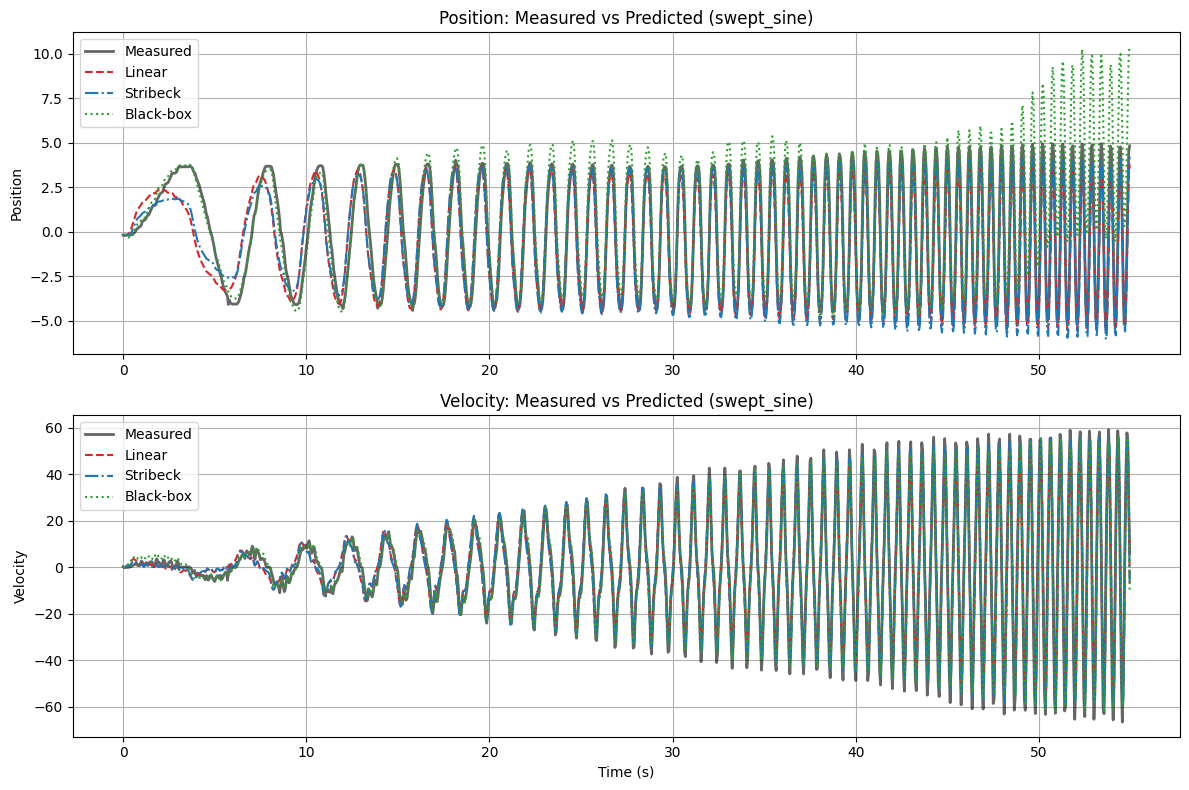

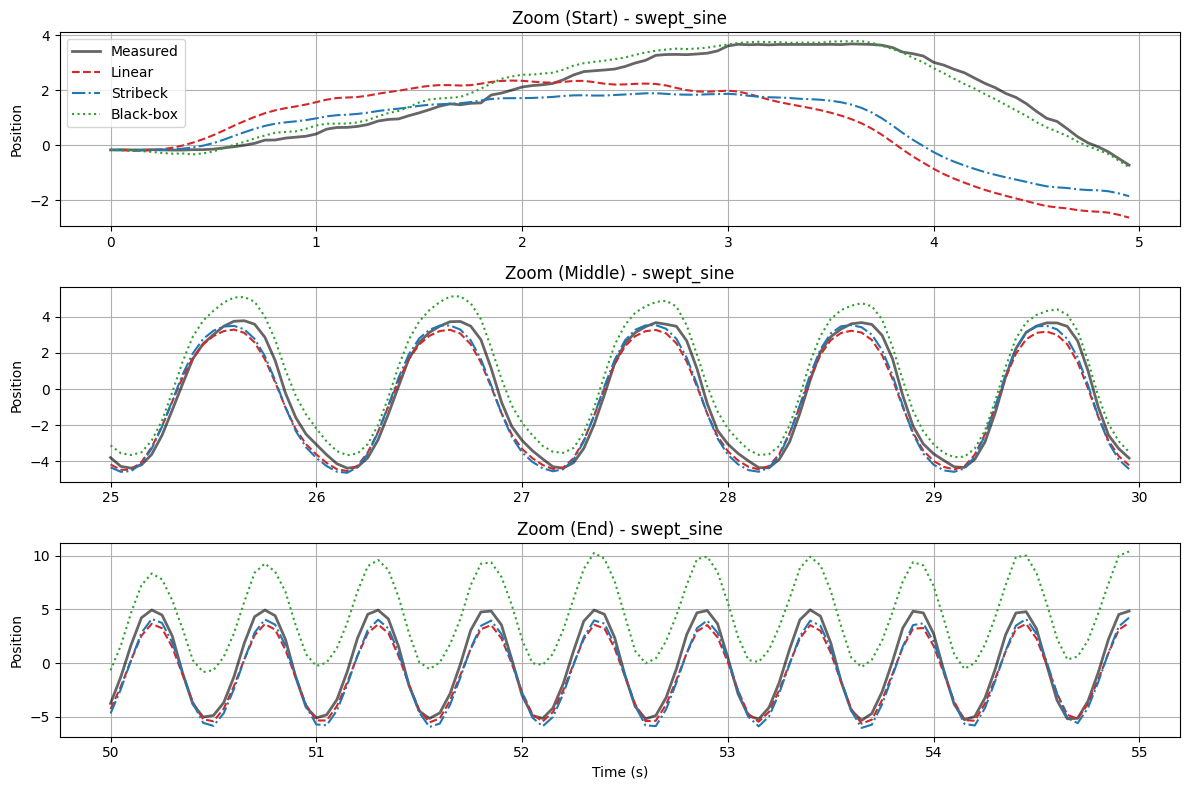

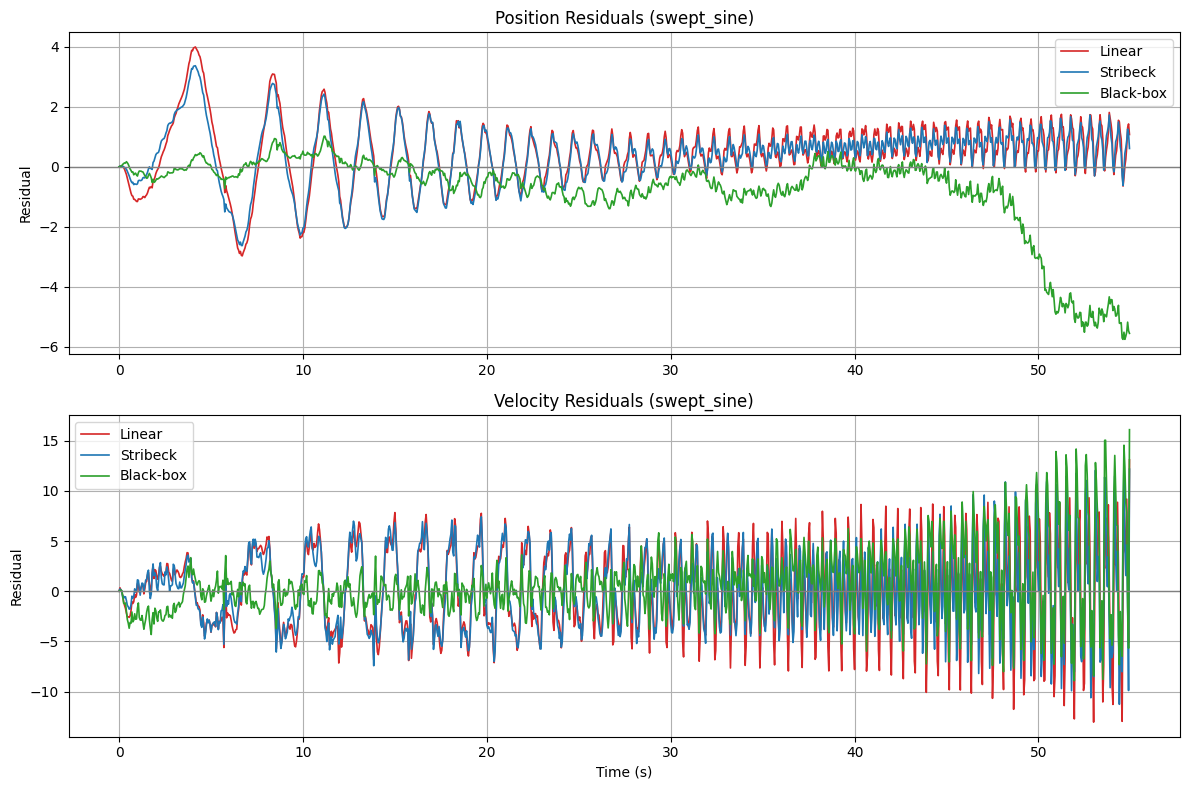

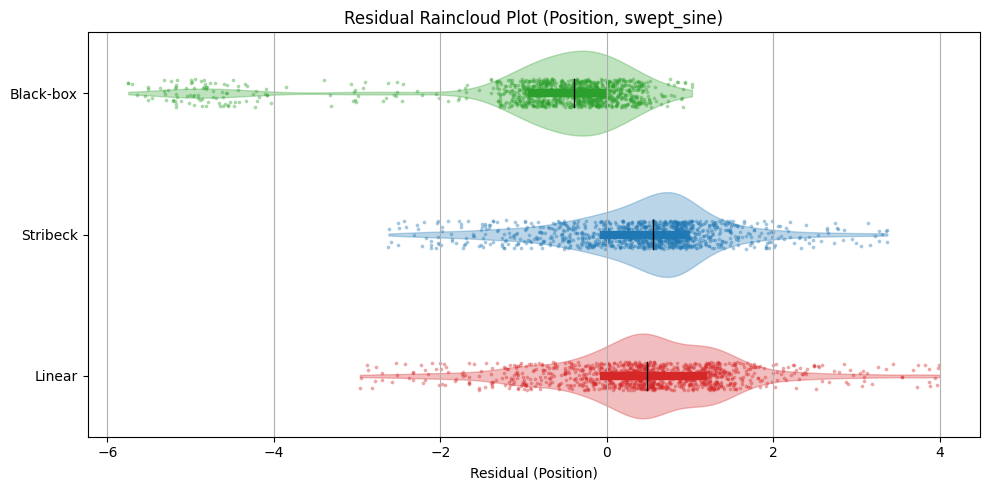

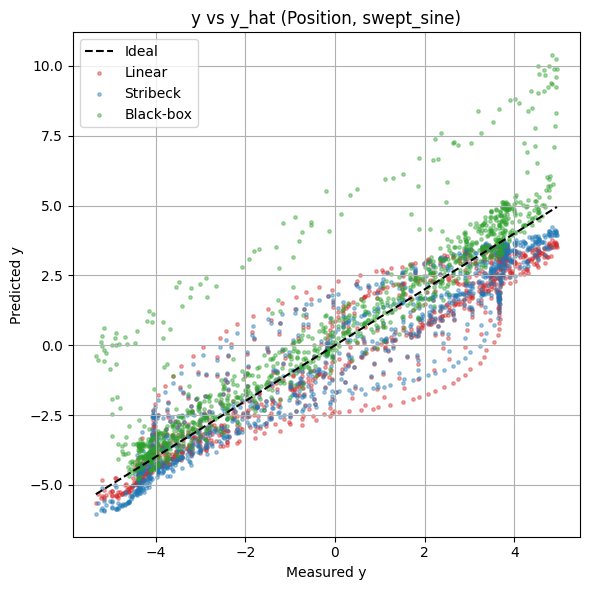

In [157]:
# Metrics tables for selected dataset
print(f"Metrics - Position ({plot_dataset})")
print("Model        RMSE      R2        FIT%")
for name in models_test.keys():
    m = metrics_test[name]
    print(f"{name:<12} {m['rmse_pos']:<9.4f} {m['r2_pos']:<8.4f} {m['fit_pos']:<8.2f}")

print(f"Metrics - Velocity ({plot_dataset})")
print("Model        RMSE      R2        FIT%")
for name in models_test.keys():
    m = metrics_test[name]
    print(f"{name:<12} {m['rmse_vel']:<9.4f} {m['r2_vel']:<8.4f} {m['fit_vel']:<8.2f}")

# Predictions vs measured
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t_test, y_sim_test[:, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models_test.items():
    plt.plot(t_test, pred[:, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.title(f"Position: Measured vs Predicted ({plot_dataset})")

plt.subplot(2, 1, 2)
plt.plot(t_test, y_sim_test[:, 1], 'k-', alpha=0.6, linewidth=2, label='Measured')
for name, pred in models_test.items():
    plt.plot(t_test, pred[:, 1], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)
plt.title(f"Velocity: Measured vs Predicted ({plot_dataset})")
plt.tight_layout()
plt.show()

# Zooms
win_sec = 5.0
win_n = int(win_sec / Ts_test)
starts = [0, max(0, (len(t_test) - win_n) // 2), max(0, len(t_test) - win_n)]
labels = ["Start", "Middle", "End"]

plt.figure(figsize=(12, 8))
for i, s in enumerate(starts):
    e = min(len(t_test), s + win_n)
    plt.subplot(3, 1, i + 1)
    plt.plot(t_test[s:e], y_sim_test[s:e, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
    for name, pred in models_test.items():
        plt.plot(t_test[s:e], pred[s:e, 0], linestyle=styles[name], color=colors[name], linewidth=1.5, label=name)
    plt.title(f"Zoom ({labels[i]}) - {plot_dataset}")
    plt.ylabel('Position')
    plt.grid(True)
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Residuals all models
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for name in models_test.keys():
    plt.plot(t_test, residuals_test[name]['pos'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title(f'Position Residuals ({plot_dataset})')
plt.ylabel('Residual')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
for name in models_test.keys():
    plt.plot(t_test, residuals_test[name]['vel'], color=colors[name], linewidth=1.2, label=name)
plt.axhline(0, color='gray', linewidth=1)
plt.title(f'Velocity Residuals ({plot_dataset})')
plt.ylabel('Residual')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Raincloud (position residuals)
from scipy.stats import gaussian_kde
labels_test = list(models_test.keys())
res_list_test = [residuals_test[name]['pos'] for name in labels_test]

plt.figure(figsize=(10, 5))
for i, (label, res) in enumerate(zip(labels_test, res_list_test)):
    res = res[np.isfinite(res)]
    kde = gaussian_kde(res)
    xs = np.linspace(np.min(res), np.max(res), 200)
    ys = kde(xs)
    ys = ys / ys.max() * 0.3
    plt.fill_between(xs, i + ys, i - ys, color=colors[label], alpha=0.3)
    q1, q2, q3 = np.percentile(res, [25, 50, 75])
    plt.plot([q1, q3], [i, i], color=colors[label], linewidth=6)
    plt.plot([q2, q2], [i-0.1, i+0.1], color='k', linewidth=1)
    jitter = (np.random.rand(len(res)) - 0.5) * 0.2
    plt.scatter(res, i + jitter, s=3, color=colors[label], alpha=0.3)

plt.yticks(range(len(labels_test)), labels_test)
plt.xlabel('Residual (Position)')
plt.title(f'Residual Raincloud Plot (Position, {plot_dataset})')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# y vs yhat
plt.figure(figsize=(6, 6))
plt.plot([y_sim_test[:,0].min(), y_sim_test[:,0].max()], [y_sim_test[:,0].min(), y_sim_test[:,0].max()], 'k--', label='Ideal')
for name, pred in models_test.items():
    plt.scatter(y_sim_test[:,0], pred[:,0], s=6, alpha=0.4, color=colors[name], label=name)
plt.xlabel('Measured y')
plt.ylabel('Predicted y')
plt.title(f'y vs y_hat (Position, {plot_dataset})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 16) Test Diagnostics (ACF and Spectra)

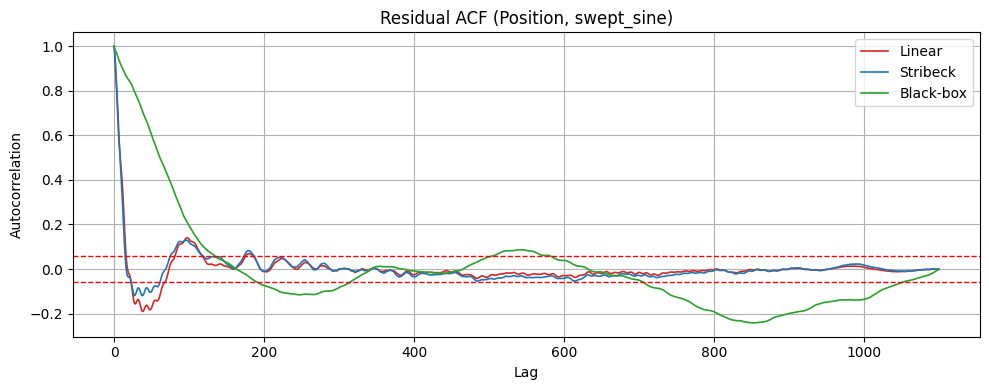

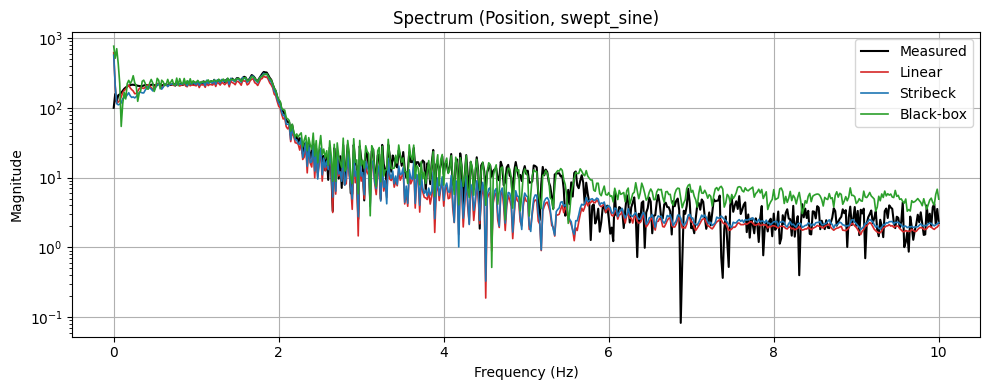

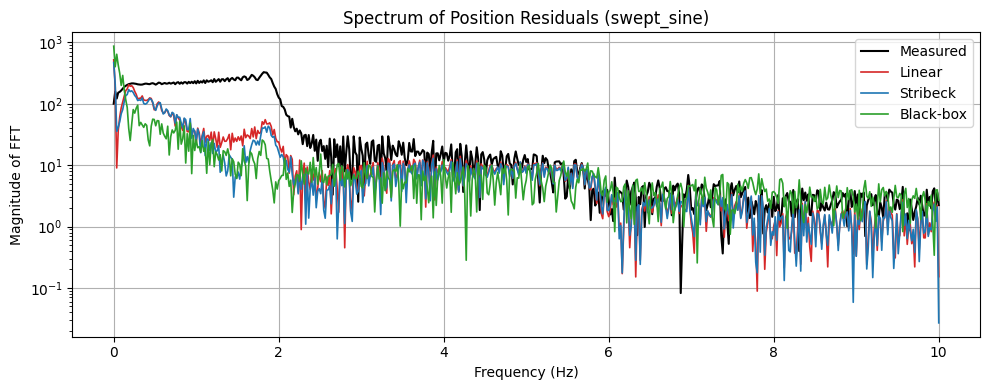

In [158]:
# ACF (position) for selected dataset
N_test = len(t_test)
max_lag_test = min(2000, N_test - 1)
conf_test = 1.96 / np.sqrt(N_test)

plt.figure(figsize=(10, 4))
for name in models_test.keys():
    res = residuals_test[name]['pos'] - np.mean(residuals_test[name]['pos'])
    acf = np.correlate(res, res, mode='full')
    acf = acf[N_test-1:N_test+max_lag_test] / acf[N_test-1]
    plt.plot(np.arange(0, max_lag_test + 1), acf, color=colors[name], linewidth=1.2, label=name)

plt.axhline(conf_test, color='red', linestyle='--', linewidth=1)
plt.axhline(-conf_test, color='red', linestyle='--', linewidth=1)
plt.title(f'Residual ACF (Position, {plot_dataset})')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Spectrum: measured vs predictions
freqs_test = np.fft.rfftfreq(len(t_test), d=Ts_test)
Y_meas_test = np.fft.rfft(y_sim_test[:, 0])

plt.figure(figsize=(10, 4))
plt.semilogy(freqs_test, np.abs(Y_meas_test), color='k', label='Measured')
for name, pred in models_test.items():
    Y_pred = np.fft.rfft(pred[:, 0])
    plt.semilogy(freqs_test, np.abs(Y_pred), color=colors[name], linewidth=1.2, label=name)
plt.title(f'Spectrum (Position, {plot_dataset})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Residual spectrum
plt.figure(figsize=(10, 4))
plt.semilogy(freqs_test, np.abs(Y_meas_test), color='k', label='Measured')
for name in models_test.keys():
    res_fft = np.fft.rfft(residuals_test[name]['pos'])
    plt.semilogy(freqs_test, np.abs(res_fft), color=colors[name], linewidth=1.2, label=name)
plt.title(f'Spectrum of Position Residuals ({plot_dataset})')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude of FFT')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
